# EDA of datasets provided by Kaggle
The purpose of this notebook is to explore each of the datasets provided by Kaggle.
The output will be:
- comments assisting with the general understanding of the data available
- interesting insights that may influence modelling
- recommendations for feature engineering

## Train
Note, this is the largest dataset and the assumption is most of the feature engineering will be built around this dataset.

In [ ]:
from config import proj
from pyspark.sql import SparkSession
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pyspark.pandas as ps
import pyspark.sql.functions as sf
import warnings

warnings.filterwarnings('ignore')

spark = SparkSession.builder.getOrCreate()
train = spark.read.parquet(str(proj.Config.paths.get("data_proc").joinpath("train.parquet")))

In [2]:
train.show(5)

+----------+---------+--------+----------+-----------+
|      date|store_nbr|item_nbr|unit_sales|onpromotion|
+----------+---------+--------+----------+-----------+
|2013-04-06|       49|  586969|       7.0|       null|
|2013-04-06|       49|  587069|      21.0|       null|
|2013-04-06|       49|  587156|       6.0|       null|
|2013-04-06|       49|  587186|      22.0|       null|
|2013-04-06|       49|  589403|       9.0|       null|
+----------+---------+--------+----------+-----------+
only showing top 5 rows



Initial ideas
- date range
- any missing dates
- counts of stores, items
- unit sales distribution (overall)
- onpromo distribution over all
- time series plot (any seasonality)
- STL decomposition (trends seasonality)
- check for stationality (mean and variance stationary in time)
- missing promo flags (suggestion of treatment)
- checks for autocorrelation and partial autocorrelation

### Overview
Start by having a quick overview of the data:
- date range
- missing dates
- total and average sales plot
- max and min total sales
- returns time series
- transaction count per day (part of a different dataset provided by Kaggle)
- counts of stores, items, etc

#### Date range and total sales

In [3]:
sales_total = train.select("date", "unit_sales")\
    .groupby(train.date)\
    .agg(sf.sum('unit_sales').alias('total_unit_sales'))\
    .toPandas()

In [4]:
print(sales_total.date.min())
print(sales_total.date.max())
print(sales_total.total_unit_sales.min())
print(sales_total.total_unit_sales.max())

2013-01-01
2017-08-15
2511.6190002560616
1463083.9631341696


4.5 years worth of timeseries data, will likely not need this much for the model training.

unit sales is either weight or units sold rather than dollars (as mentioned on Kaggle)

Suggestion:
- Start with 2 years worth of data when modeling, this should give enough information about seasonality.

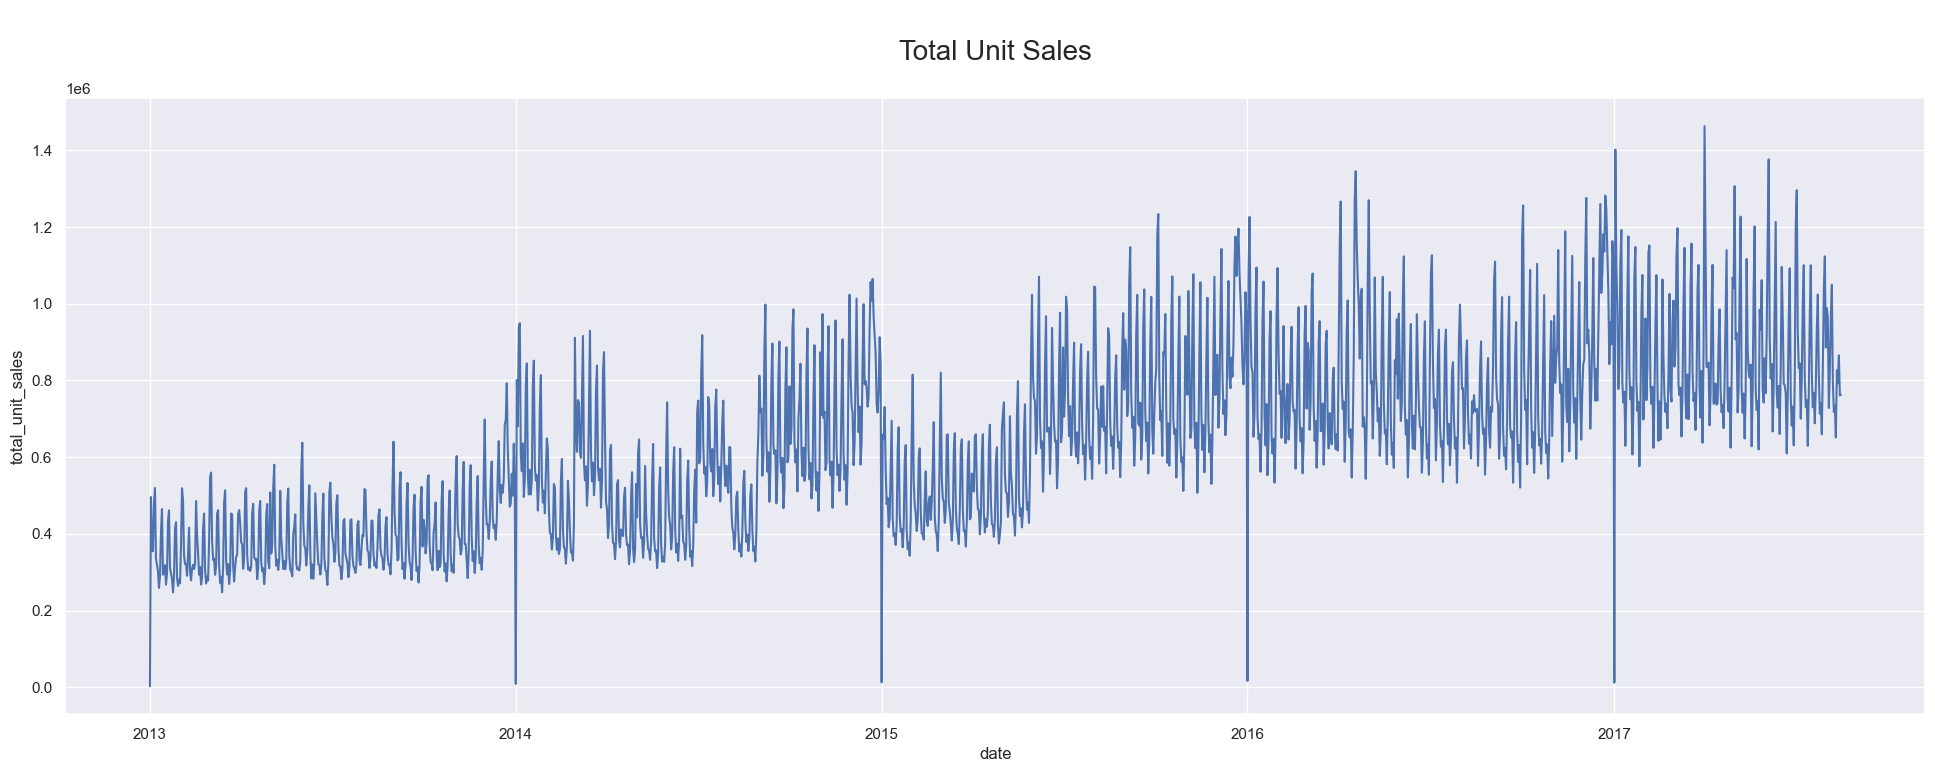

In [5]:
sns.set(rc={"figure.figsize":(24,8)})
ax=sns.lineplot(data=sales_total,x="date",y="total_unit_sales")
ax.axes.set_title("\nTotal Unit Sales\n",fontsize=20);

#### Max and min total sales

In [6]:
print(sales_total[sales_total.total_unit_sales == sales_total.total_unit_sales.min()])
sales_total.sort_values('total_unit_sales').head(10)

           date  total_unit_sales
218  2013-01-01          2511.619


,date,total_unit_sales
218,2013-01-01,2511.619000
315,2014-01-01,8602.065404
597,2017-01-01,12082.500986
1226,2015-01-01,12773.616996
903,2016-01-01,16433.394001
251,2013-01-24,247245.691038
129,2013-03-14,247541.420012
244,2013-01-10,258982.003025
225,2013-01-29,264488.818018
296,2013-06-27,266525.458982


In [7]:
print(sales_total[sales_total.total_unit_sales == sales_total.total_unit_sales.max()])
sales_total.sort_values('total_unit_sales', ascending=False).head(10).round(2)

            date  total_unit_sales
1047  2017-04-01      1.463084e+06


,date,total_unit_sales
1047,2017-04-01,1463083.96
684,2017-01-02,1402305.37
1039,2017-06-04,1376511.52
591,2016-04-18,1345920.60
1045,2017-05-01,1306699.37
1012,2017-07-02,1296379.22
707,2016-12-23,1282145.52
455,2016-12-04,1276195.04
652,2016-04-17,1271833.74
632,2016-05-01,1270121.21


Clear trend upwards throughout the period. Likely due to additional stores, but could also be due to additional foot traffic in stores.

Can see a dip every year on new year's day. Most stores are probably shut on this day.

Large sale days don't show much of a pattern. But could be around Christmas or Easter. Will need to check this with the holiday data.

#### Average sales

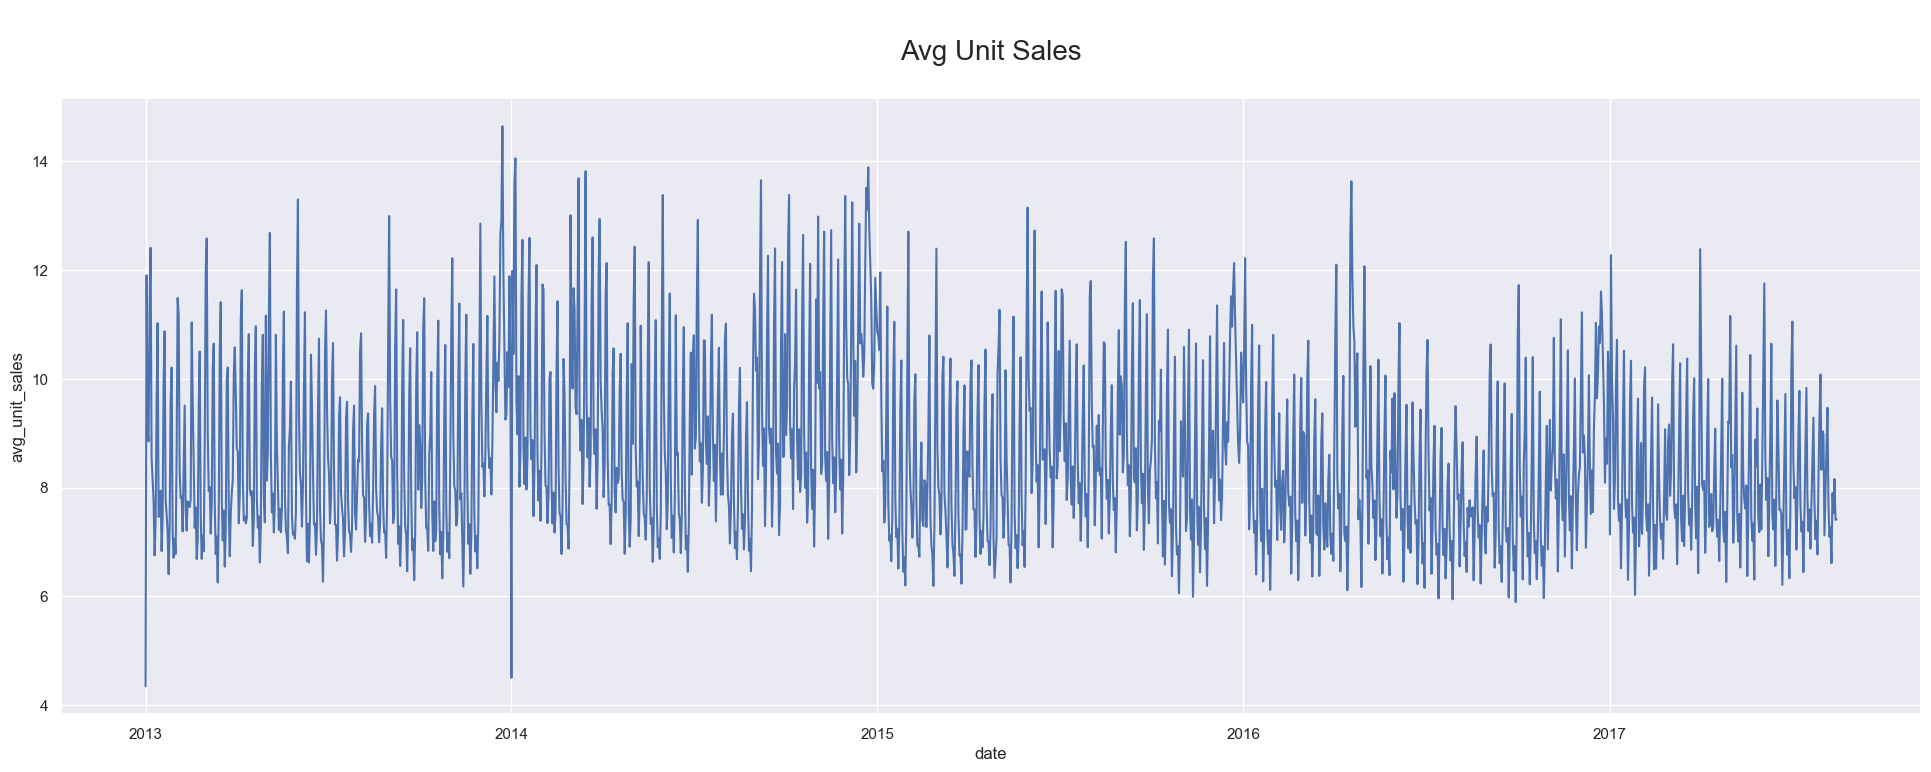

In [8]:
sales_avg = train.select("date", "unit_sales")\
    .groupby(train.date)\
    .agg(sf.avg("unit_sales").alias("avg_unit_sales"))\
    .toPandas()

ax=sns.lineplot(data=sales_avg,x="date",y="avg_unit_sales")
ax.axes.set_title("\nAvg Unit Sales\n",fontsize=20);

Average sales per day seems pretty consistent, variance reduces a little bit by the looks of it

Can see spikes around Christmas.

#### Total returns

#### Transaction count

#### Item and store counts

#### Top selling items and stores

#### Holiday impacts

#### Oil impacts